In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.callbacks import ReduceLROnPlateau, CSVLogger, EarlyStopping, ModelCheckpoint

!pip install opencv-python
import cv2
from google.colab.patches import cv2_imshow

Using TensorFlow backend.


In [0]:
# Connecting Drive to save models
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# !cp '/content/gdrive/My Drive/cifar-10-python.tar.gz' '/content/cifar-10-batches-py.tar.gz'
# !cp '/content/cifar-10-batches-py.tar.gz' ~/.keras/datasets/
# ls ~/.keras/datasets
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_rows, img_cols, img_channels =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

In [0]:
X_Test = test_features
Y_Test = test_labels

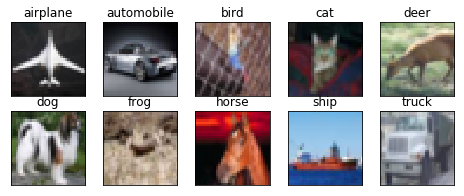

In [0]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

# Assignment 9 - Initial Model


In [0]:
# Define the model

# Model:
# Initial Convolution (16, 3, 3) + BN | Output: 32

# Conv Block 1 (3X3, same padding) + BN: 16 + 32 | Output: 32
# Transition Block 1: MaxPool + Conv (16, 1, 1) + BN + DropOut | Output: 16

# Conv Block 2 (3X3, same padding) + BN: 32 + 64 | Output: 16
# Transition Block 2: MaxPool + Conv (32, 1, 1) + BN + DropOut | Output: 8

# Conv Block 3 (3X3, same padding) + BN: 64 + 128 | Output: 8
# Transition Block 3: MaxPool + Conv (64, 1, 1) + BN + DropOut | Output: 4

# Conv Block 4 (3X3, same padding) + BN: 64 + 64 | Output: 4

# Final Conv (10, 4, 4) | Output: 1
# GAP + Softmax

#-----------------------------------------------------------------------------------#

model = Sequential()

# Inital Conv
model.add(Convolution2D(16, 3, 3, border_mode = 'same', input_shape = (32, 32, 3))) #32
model.add(Activation('relu'))
model.add(BatchNormalization())

# Conv Block 1: 16 + 32
model.add(Convolution2D(16, 3, 3, border_mode = 'same')) #32
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Convolution2D(32, 3, 3, border_mode = 'same')) #32
model.add(Activation('relu'))
model.add(BatchNormalization())

# Transition Block 1: MP + 16 + DO
model.add(MaxPooling2D(pool_size = (2, 2))) #16
model.add(Convolution2D(16, 1, 1)) #16
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

# Conv Block 2: 32 + 64
model.add(Convolution2D(32, 3, 3, border_mode = 'same')) #16
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Convolution2D(64, 3, 3, border_mode = 'same')) #16
model.add(Activation('relu'))
model.add(BatchNormalization())

# Transition Block 2: MP + 32 + DO
model.add(MaxPooling2D(pool_size = (2, 2))) #8
model.add(Convolution2D(32, 1, 1)) #8
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

# Conv Block 3: 64 + 128
model.add(Convolution2D(64, 3, 3, border_mode = 'same')) #8
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Convolution2D(128, 3, 3, border_mode = 'same')) #8
model.add(Activation('relu'))
model.add(BatchNormalization())

# Transition Block 3: MP + 64 + DO
model.add(MaxPooling2D(pool_size = (2, 2))) #4
model.add(Convolution2D(64, 1, 1)) #4
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

# Conv Block 4: 64 + 64
model.add(Convolution2D(64, 3, 3, border_mode = 'same')) #4
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Convolution2D(64, 3, 3, border_mode = 'same', name = 'ABC')) #4
model.add(Activation('relu', name = 'ABC_RELU'))
model.add(BatchNormalization())

# Final Conv: 10 channels to bring down dimension to 1X1
model.add(Convolution2D(10, 4, 4, name = 'last_layer')) #1
model.add(Activation('relu', name = 'last_layer_relu'))

# Flatten + Softmax
model.add(GlobalAveragePooling2D())
model.add(Activation('softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

W0624 10:29:09.971659 140614936393600 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), input_shape=(32, 32, 3..., padding="same")`
  """
W0624 10:29:09.990176 140614936393600 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0624 10:29:09.993432 140614936393600 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0624 10:29:10.024316 140614936393600 deprecation_wrapper.py:119] From /usr/local/lib/pytho

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 16)        448       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 16)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 16)        64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 16)        2320      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 16)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 16)        64        
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        4640      
__________

In [0]:
filepath="/content/gdrive/My Drive/EVA/Project 9 - Best_2.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, callbacks=[<keras.ca..., steps_per_epoch=200, epochs=100)`
W0624 10:29:25.172132 140614936393600 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a futur

Epoch 1/100
200/200 [==============================] - 12s 62ms/step - loss: 1.7860 - acc: 0.3669 - val_loss: 1.6365 - val_acc: 0.4700

Epoch 00001: val_acc improved from -inf to 0.47000, saving model to /content/gdrive/My Drive/EVA/Project 9 - Best_2.hdf5
Epoch 2/100
200/200 [==============================] - 8s 39ms/step - loss: 1.3453 - acc: 0.5225 - val_loss: 1.3731 - val_acc: 0.5358

Epoch 00002: val_acc improved from 0.47000 to 0.53580, saving model to /content/gdrive/My Drive/EVA/Project 9 - Best_2.hdf5
Epoch 3/100
200/200 [==============================] - 8s 39ms/step - loss: 1.1260 - acc: 0.5990 - val_loss: 1.1209 - val_acc: 0.6082

Epoch 00003: val_acc improved from 0.53580 to 0.60820, saving model to /content/gdrive/My Drive/EVA/Project 9 - Best_2.hdf5
Epoch 4/100
200/200 [==============================] - 8s 39ms/step - loss: 0.9760 - acc: 0.6542 - val_loss: 0.9429 - val_acc: 0.6710

Epoch 00004: val_acc improved from 0.60820 to 0.67100, saving model to /content/gdrive/My 

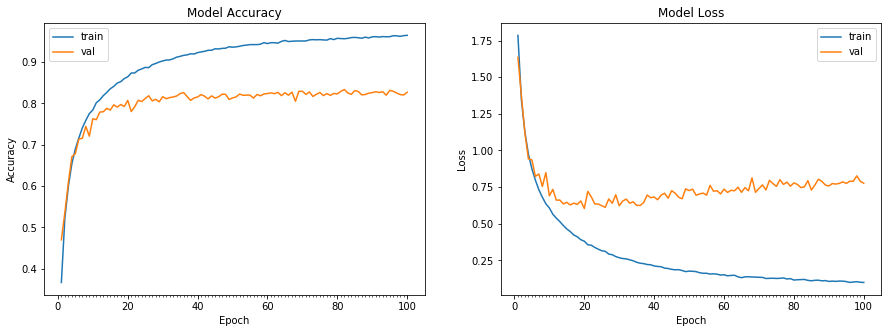

Accuracy on test data is: 82.73


In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, 
                                              train_labels, 
                                              batch_size = 250),
                                 samples_per_epoch = train_features.shape[0],
                                 nb_epoch = 100, 
                                 validation_data = (test_features, test_labels),
                                 verbose = 1,
                                callbacks = [checkpoint])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

In [0]:
# Loading best model from the initial training
model.load_weights("/content/gdrive/My Drive/EVA/Project 9 - Best_2.hdf5")

In [0]:
# Evaluating the model on the test data
score = model.evaluate(test_features, test_labels, verbose=0)

In [0]:
# Printing test score
print(score)

[0.7469568594932556, 0.8339]


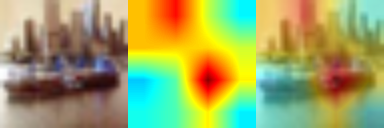

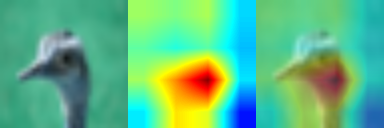

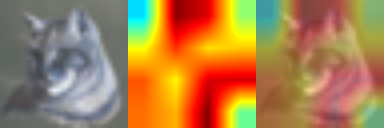

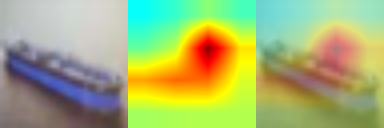

In [23]:
n = [132, 765, 432, 999]

for j in range(len(n)):
  x = test_features[n[j]]
  preds = model.predict(x.reshape(1,32,32,3))
  class_idx = np.argmax(preds[0])
  class_output = model.output[:, class_idx]
  last_conv_layer = model.get_layer("ABC_RELU")

  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x.reshape(1,32,32,3)])
  for i in range(10):
      conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)

  img = X_Test[n[j]]

  # img = cv2.imread(test_features[34])
  # heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  img = cv2.resize(img, (128, 128))
  heatmap = cv2.resize(heatmap, (128, 128))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)  
  horizontal = np.hstack((img, heatmap, superimposed_img))
  horizontal_concat = np.concatenate((img, heatmap, superimposed_img), axis=1)
  cv2_imshow(horizontal_concat)
#   cv2_imshow(img)
#   cv2_imshow(heatmap)
#   cv2_imshow(superimposed_img)

# New Model With Cutout

In [42]:
# Define the model

# Model:
# Initial Convolution (16, 3, 3) + BN | Output: 32

# Conv Block 1 (3X3, same padding) + BN: 16 + 32 | Output: 32
# Transition Block 1: MaxPool + Conv (16, 1, 1) + BN + DropOut | Output: 16

# Conv Block 2 (3X3, same padding) + BN: 32 + 64 | Output: 16
# Transition Block 2: MaxPool + Conv (32, 1, 1) + BN + DropOut | Output: 8

# Conv Block 3 (3X3, same padding) + BN: 64 + 128 | Output: 8
# Transition Block 3: MaxPool + Conv (64, 1, 1) + BN + DropOut | Output: 4

# Conv Block 4 (3X3, same padding) + BN: 64 + 64 | Output: 4

# Final Conv (10, 4, 4) | Output: 1
# GAP + Softmax

#-----------------------------------------------------------------------------------#

model = Sequential()

# Inital Conv
model.add(Convolution2D(16, 3, 3, border_mode = 'same', input_shape = (32, 32, 3))) #32
model.add(Activation('relu'))
model.add(BatchNormalization())

# Conv Block 1: 16 + 32
model.add(Convolution2D(16, 3, 3, border_mode = 'same')) #32
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Convolution2D(32, 3, 3, border_mode = 'same')) #32
model.add(Activation('relu'))
model.add(BatchNormalization())

# Transition Block 1: MP + 16 + DO
model.add(MaxPooling2D(pool_size = (2, 2))) #16
model.add(Convolution2D(16, 1, 1)) #16
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

# Conv Block 2: 32 + 64
model.add(Convolution2D(32, 3, 3, border_mode = 'same')) #16
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Convolution2D(64, 3, 3, border_mode = 'same')) #16
model.add(Activation('relu'))
model.add(BatchNormalization())

# Transition Block 2: MP + 32 + DO
model.add(MaxPooling2D(pool_size = (2, 2))) #8
model.add(Convolution2D(32, 1, 1)) #8
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

# Conv Block 3: 64 + 128
model.add(Convolution2D(64, 3, 3, border_mode = 'same')) #8
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Convolution2D(128, 3, 3, border_mode = 'same')) #8
model.add(Activation('relu'))
model.add(BatchNormalization())

# Transition Block 3: MP + 64 + DO
model.add(MaxPooling2D(pool_size = (2, 2))) #4
model.add(Convolution2D(64, 1, 1)) #4
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

# Conv Block 4: 64 + 64
model.add(Convolution2D(64, 3, 3, border_mode = 'same')) #4
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Convolution2D(64, 3, 3, border_mode = 'same', name = 'ABC')) #4
model.add(Activation('relu', name = 'ABC_RELU'))
model.add(BatchNormalization())

# Final Conv: 10 channels to bring down dimension to 1X1
model.add(Convolution2D(10, 4, 4, name = 'last_layer')) #1
model.add(Activation('relu', name = 'last_layer_relu'))

# Flatten + Softmax
model.add(GlobalAveragePooling2D())
model.add(Activation('softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), input_shape=(32, 32, 3..., padding="same")`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), padding="same")`
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same")`
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (1, 1))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Update your `Conv2D` call to 

In [43]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_45 (Conv2D)           (None, 32, 32, 16)        448       
_________________________________________________________________
activation_49 (Activation)   (None, 32, 32, 16)        0         
_________________________________________________________________
batch_normalization_49 (Batc (None, 32, 32, 16)        64        
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 32, 32, 16)        2320      
_________________________________________________________________
activation_50 (Activation)   (None, 32, 32, 16)        0         
_________________________________________________________________
batch_normalization_50 (Batc (None, 32, 32, 16)        64        
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 32, 32, 32)        4640      
__________

In [0]:
filepath="/content/gdrive/My Drive/EVA/Project 9 - Best_2_Cut.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [0]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, callbacks=[<keras.ca..., steps_per_epoch=200, epochs=100)`


Epoch 1/100
200/200 [==============================] - 13s 63ms/step - loss: 1.8874 - acc: 0.3224 - val_loss: 1.6942 - val_acc: 0.4434

Epoch 00001: val_acc improved from -inf to 0.44340, saving model to /content/gdrive/My Drive/EVA/Project 9 - Best_2_Cut.hdf5
Epoch 2/100
200/200 [==============================] - 8s 41ms/step - loss: 1.4477 - acc: 0.4768 - val_loss: 1.3851 - val_acc: 0.5259

Epoch 00002: val_acc improved from 0.44340 to 0.52590, saving model to /content/gdrive/My Drive/EVA/Project 9 - Best_2_Cut.hdf5
Epoch 3/100
200/200 [==============================] - 8s 41ms/step - loss: 1.2511 - acc: 0.5508 - val_loss: 1.2786 - val_acc: 0.5740

Epoch 00003: val_acc improved from 0.52590 to 0.57400, saving model to /content/gdrive/My Drive/EVA/Project 9 - Best_2_Cut.hdf5
Epoch 4/100
200/200 [==============================] - 8s 41ms/step - loss: 1.1280 - acc: 0.5937 - val_loss: 1.0934 - val_acc: 0.6248

Epoch 00004: val_acc improved from 0.57400 to 0.62480, saving model to /conten

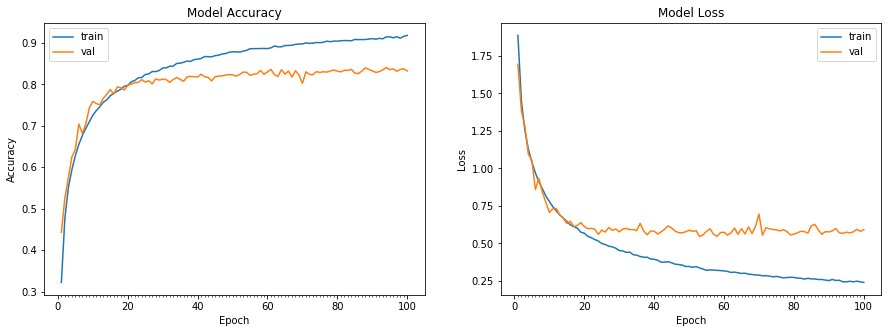

Accuracy on test data is: 83.21


In [46]:
from keras.preprocessing.image import ImageDataGenerator
# from random_eraser import get_random_eraser

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False,
                            preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=False))


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, 
                                              train_labels, 
                                              batch_size = 250),
                                 samples_per_epoch = train_features.shape[0],
                                 nb_epoch = 100, 
                                 validation_data = (test_features, test_labels),
                                 verbose = 1,
                                callbacks = [checkpoint])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

In [0]:
# Loading best model from the initial training
model.load_weights("/content/gdrive/My Drive/EVA/Project 9 - Best_2_Cut.hdf5")

In [0]:
# Evaluating the model on the test data
score = model.evaluate(test_features, test_labels, verbose=0)

In [54]:
# Printing test score
print(score)

[0.5674781847953796, 0.8403]


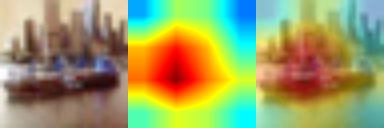

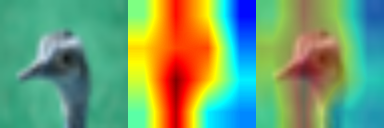

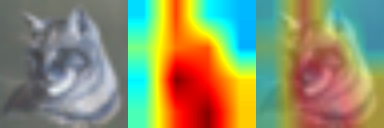

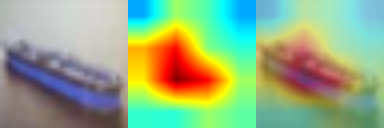

In [55]:
n = [132, 765, 432, 999]

for j in range(len(n)):
  x = test_features[n[j]]
  preds = model.predict(x.reshape(1,32,32,3))
  class_idx = np.argmax(preds[0])
  class_output = model.output[:, class_idx]
  last_conv_layer = model.get_layer("ABC_RELU")

  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x.reshape(1,32,32,3)])
  for i in range(10):
      conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)

  img = X_Test[n[j]]

  # img = cv2.imread(test_features[34])
  # heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  img = cv2.resize(img, (128, 128))
  heatmap = cv2.resize(heatmap, (128, 128))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)  
  horizontal = np.hstack((img, heatmap, superimposed_img))
  horizontal_concat = np.concatenate((img, heatmap, superimposed_img), axis=1)
  cv2_imshow(horizontal_concat)
#   cv2_imshow(img)
#   cv2_imshow(heatmap)
#   cv2_imshow(superimposed_img)